### 1. Import dependecies

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional,Dict

### 2. T-SNE implementation

In [110]:
df = pd.read_csv('../data/processed/countries_pca_4components.csv')
df.head()

,pc_1,pc_2,pc_3,pc_4
0,1.808111,0.764255,-0.592153,-0.306737
1,-0.078296,-0.308491,0.124619,-0.320582
2,0.222983,-0.797755,0.188229,-0.461312
3,2.476413,-0.447791,0.061881,0.062571
4,-0.468081,-0.498966,-0.252816,-0.136022


In [111]:
# t-SNE Implementation (FIXED)
def pairwise_distances_sq(X: np.ndarray) -> np.ndarray:
    """Compute squared Euclidean distances between all pairs of points."""
    n = X.shape[0]
    distances = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                distances[i, j] = np.sum((X[i] - X[j]) ** 2)
    
    return distances

def compute_pca_cov(X_std: np.ndarray, k: int) -> Dict:
    """Internal PCA helper - used silently for dimensionality reduction."""
    # Compute covariance matrix
    cov_matrix = np.cov(X_std.T)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Take first k components
    components = eigenvectors[:, :k]
    explained_variance = eigenvalues[:k]
    
    return {
        'components': components,
        'explained_variance': explained_variance,
        'explained_variance_ratio': explained_variance / np.sum(eigenvalues)
    }

def Hbeta(D: np.ndarray, beta: float) -> Tuple[float, np.ndarray]:
    """Compute entropy and probability distribution for given beta."""
    # Avoid division by zero
    D = D + 1e-12
    
    # Compute probabilities
    P = np.exp(-D * beta)
    sum_P = np.sum(P)
    
    if sum_P == 0:
        H = 0
        P = np.zeros_like(D)
    else:
        P = P / sum_P
        H = -np.sum(P * np.log(P + 1e-12))
    
    return H, P

def binary_search_beta(D_row: np.ndarray, target_perp: float, tol: float = 1e-5, max_iter: int = 50) -> np.ndarray:
    """Binary search to find beta that gives target perplexity."""
    # Remove the diagonal element (distance to self)
    D_row = D_row[D_row > 0]
    
    if len(D_row) == 0:
        return np.array([])
    
    # Binary search for beta
    beta_min = 0
    beta_max = np.inf
    beta = 1.0
    
    for _ in range(max_iter):
        H, P = Hbeta(D_row, beta)
        perp = np.exp(H)
        
        if abs(perp - target_perp) < tol:
            break
            
        if perp > target_perp:
            beta_min = beta
            if beta_max == np.inf:
                beta = beta * 2
            else:
                beta = (beta + beta_max) / 2
        else:
            beta_max = beta
            beta = (beta + beta_min) / 2
    
    return P


In [112]:
def compute_P_matrix(X: np.ndarray, perplexity: float) -> np.ndarray:
    """Compute the P matrix for t-SNE with given perplexity."""
    n = X.shape[0]
    P = np.zeros((n, n))
    
    # Compute pairwise distances
    distances = pairwise_distances_sq(X)
    
    # For each point, find the appropriate beta and compute probabilities
    for i in range(n):
        D_row = distances[i]
        P_row = binary_search_beta(D_row, perplexity)
        
        if len(P_row) > 0:
            # Find the indices where we have valid probabilities
            valid_indices = D_row > 0
            P[i, valid_indices] = P_row
    
    # Symmetrize the P matrix
    P = (P + P.T) / (2 * n)
    
    # Normalize
    P = P / np.sum(P)
    
    return P

def initialize_embedding(n: int, method: str = "random", X_high: Optional[np.ndarray] = None) -> np.ndarray:
    """Initialize 2D embedding for t-SNE."""
    if method == "random":
        # Random initialization
        Y = np.random.normal(0, 1e-4, (n, 2))
    elif method == "pca" and X_high is not None:
        # PCA initialization
        pca_result = compute_pca_cov(X_high, 2)
        Y = X_high @ pca_result['components']
    else:
        # Default to random
        Y = np.random.normal(0, 1e-4, (n, 2))
    
    return Y


In [113]:
def run_tsne(X: np.ndarray, perplexity: float, n_iter: int = 1000, learning_rate: float = 200.0, 
             early_exaggeration: float = 12.0, early_exaggeration_iter: int = 250,
             init_method: str = "random") -> Optional[np.ndarray]:
    """Run t-SNE algorithm."""
    n = X.shape[0]
    
    # Compute P matrix
    print("Computing P matrix...")
    P = compute_P_matrix(X, perplexity)
    
    # Initialize embedding
    print("Initializing embedding...")
    Y = initialize_embedding(n, init_method, X)
    
    # Gradient descent
    print("Running gradient descent...")
    for iter_num in range(n_iter):
        # Compute Q matrix (t-distribution)
        distances = pairwise_distances_sq(Y)
        Q = 1 / (1 + distances)
        np.fill_diagonal(Q, 0)
        Q = Q / np.sum(Q)
        
        # Compute gradient
        # Create distance matrix for gradient computation
        diff = Y[:, np.newaxis, :] - Y[np.newaxis, :, :]  # Shape: (n, n, 2)
        
        if iter_num < early_exaggeration_iter:
            # Early exaggeration phase
            exaggeration = early_exaggeration
        else:
            # Normal phase
            exaggeration = 1.0
        
        # Compute gradient for each dimension
        grad = np.zeros_like(Y)
        for i in range(n):
            for j in range(n):
                if i != j:
                    grad[i] += 4 * exaggeration * (P[i, j] - Q[i, j]) * Q[i, j] * (Y[i] - Y[j])
        
        # Update Y
        Y = Y - learning_rate * grad
        
        # Print progress
        if iter_num % 100 == 0:
            print(f"Iteration {iter_num}/{n_iter}")
    
    print("t-SNE completed!")
    return Y

def plot_tsne(Y: np.ndarray, perplexity: float, save_path: str) -> None:
    """Plot t-SNE embedding with enhanced visualization to show emerging cluster patterns."""
    plt.figure(figsize=(10, 8))
    
    # Scatter plot — add alpha and slightly larger dots for visual separation
    plt.scatter(Y[:, 0], Y[:, 1], alpha=0.7, s=70, c=Y[:, 0], cmap='viridis', edgecolor='k')
    
    # Add labels and grid
    plt.title(f't-SNE Embedding (Perplexity: {perplexity})', fontsize=14)
    plt.xlabel('t-SNE 1', fontsize=12)
    plt.ylabel('t-SNE 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Optional: add colorbar to show value variation
    plt.colorbar(label='t-SNE dimension 1 value')
    
    # Save and show
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()




Running t-SNE with perplexity = 5
Computing P matrix...


Initializing embedding...
Running gradient descent...
Iteration 0/100
t-SNE completed!


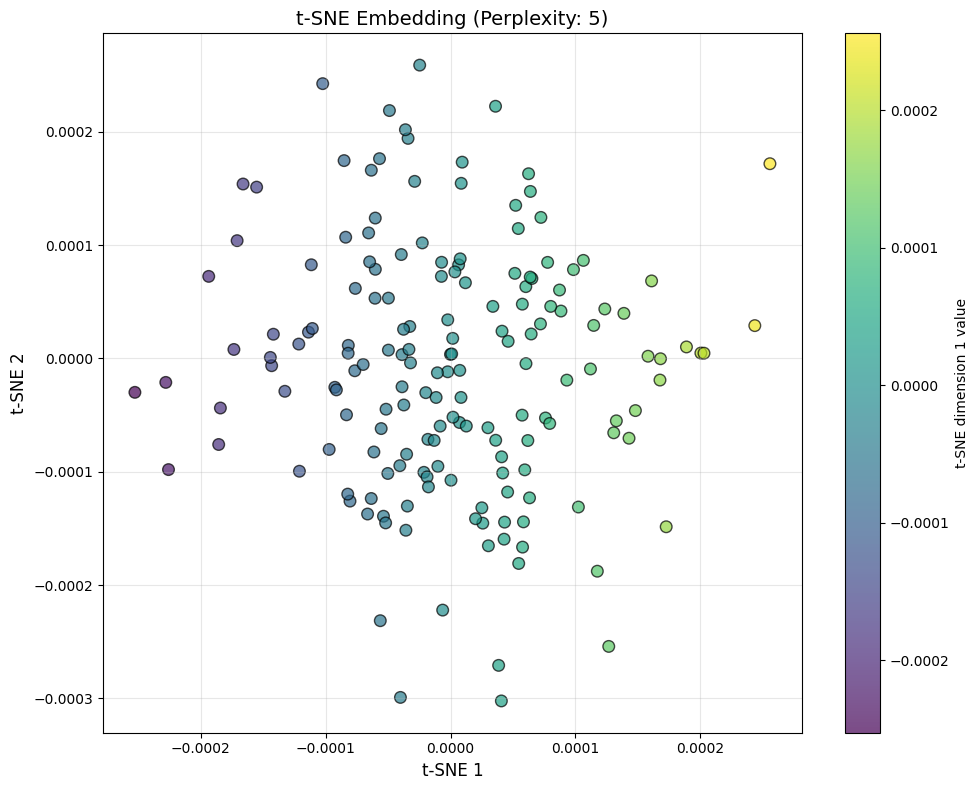

Plot saved to: ../artifacts/figures/tsne_perplexity_5.png


In [114]:
# Test the t-SNE implementation
# Load the PCA data
X = df[['pc_1', 'pc_2', 'pc_3', 'pc_4']].values

# Run t-SNE with different perplexity values
perplexity_values = [5]

for perp in perplexity_values:
    print(f"\nRunning t-SNE with perplexity = {perp}")
    Y = run_tsne(X, perplexity=perp, n_iter=100, learning_rate=10)
    
    if Y is not None:
        # Plot and save
        save_path = f'../artifacts/figures/tsne_perplexity_{perp}.png'
        plot_tsne(Y, perp, save_path)
        print(f"Plot saved to: {save_path}")
